# Telco Customer Churn Analysis

## Business Question

Which customers are at risk of churning, and what factors are most strongly associated with churn?

## Business Context

Customer churn directly impacts revenue, growth, and customer lifetime value.  
Understanding *who is likely to churn and why* allows the business to take proactive retention actions instead of reacting after customers leave.

This analysis focuses on identifying key churn drivers using customer tenure, contract type, pricing, and service usage patterns.

## Objectives

- Understand overall churn behavior
- Identify customer segments with higher churn risk
- Analyze key factors associated with churn
- Translate findings into actionable business recommendations

## Data Loading and Initial Inspection

In this step, we load the Telco Customer Churn dataset and perform a basic inspection to understand its structure, size, and available features.

The goal is to ensure data quality and identify relevant variables for churn analysis before proceeding to deeper exploration.

In [1]:
import pandas as pd
from pathlib import Path

# Define data path
DATA_DIR = Path("../../data/raw/telco")
DATA_FILE = DATA_DIR / "WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load dataset
df = pd.read_csv(DATA_FILE)

# Basic inspection
df.shape, df.head()

((7043, 21),
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV Streamin

## Data Understanding and Feature Overview

The dataset contains customer-level information related to demographics, services, contract characteristics, billing, and churn behavior.

To structure the analysis, features can be grouped into:

- **Customer profile**: demographic attributes.
- **Service usage**: subscribed telecom services.
- **Contract & billing**: pricing, payment method, and contract type.
- **Target variable**: churn status.

Understanding these groups helps frame hypotheses about why customers leave.

In [2]:
# Inspect data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Business Question

Why are customers leaving the telecom service?

Understanding churn drivers is critical to reduce revenue loss and improve customer retention strategies.

---

## Business Hypotheses

Based on domain knowledge and dataset structure, we hypothesize that:

1. Customers with **shorter tenure** are more likely to churn.
2. **Month-to-month contracts** have higher churn than long-term contracts.
3. Customers with **higher monthly charges** are more likely to churn.
4. Lack of **technical support and security services** increases churn.
5. Certain **payment methods** (e.g. electronic check) are associated with higher churn.

## Churn Overview

Before analyzing drivers of churn, we first quantify the overall churn rate to understand the magnitude of the problem.

In [3]:
# Churn distribution
churn_counts = df["Churn"].value_counts()
churn_percent = df["Churn"].value_counts(normalize=True) * 100

churn_counts, churn_percent

(Churn
 No     5174
 Yes    1869
 Name: count, dtype: int64,
 Churn
 No     73.463013
 Yes    26.536987
 Name: proportion, dtype: float64)

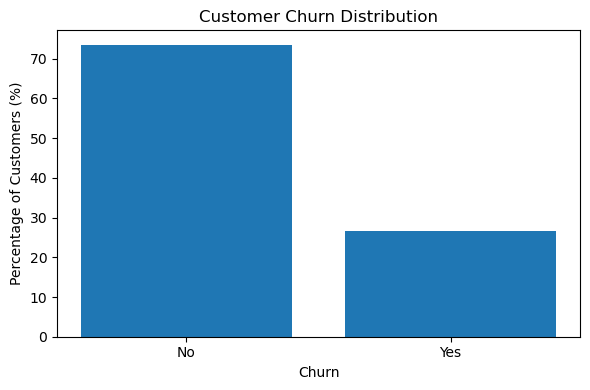

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(churn_counts.index, churn_percent.values)
plt.title("Customer Churn Distribution")
plt.ylabel("Percentage of Customers (%)")
plt.xlabel("Churn")
plt.tight_layout()
plt.savefig("../../reports/churn_distribution.png", dpi=150)
plt.show()

### Insight

Approximately one quarter of customers have churned, indicating that churn is a significant business problem rather than a marginal issue.

This confirms the need to investigate behavioral, contractual, and pricing drivers behind customer attrition.

In [6]:
# Churn rate by tenure (binned)

import pandas as pd

# Create tenure bins
df["tenure_group"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 36, 48, 60, 72],
    labels=["0-12", "13-24", "25-36", "37-48", "49-60", "61-72"],
    right=True
)

# Aggregate churn metrics by tenure group (explicit observed=True to avoid warning)
tenure_churn = (
    df.groupby("tenure_group", observed=True)
      .agg(
          customers=("customerID", "count"),
          churn_rate=("Churn", lambda x: (x == "Yes").mean() * 100)
      )
      .reset_index()
)

tenure_churn

,tenure_group,customers,churn_rate
0,0-12,2175,47.678161
1,13-24,1024,28.710938
2,25-36,832,21.634615
3,37-48,762,19.028871
4,49-60,832,14.423077
5,61-72,1407,6.609808


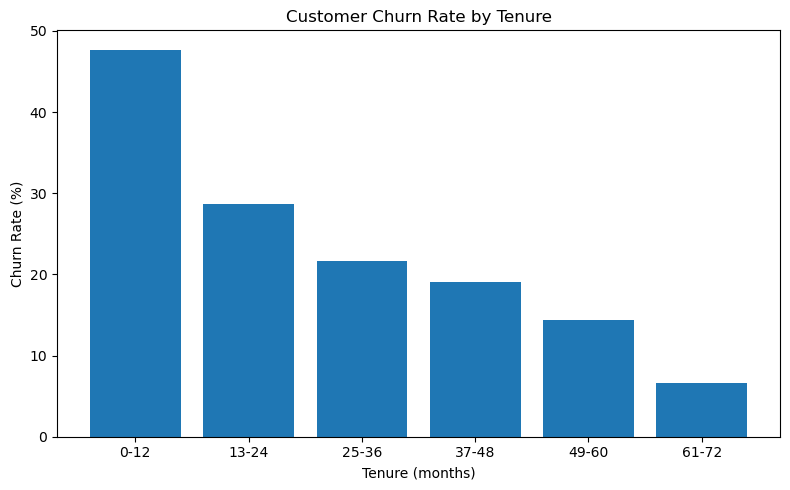

In [9]:
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure reports directory exists
Path("../../reports").mkdir(parents=True, exist_ok=True)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(tenure_churn["tenure_group"], tenure_churn["churn_rate"])
plt.xlabel("Tenure (months)")
plt.ylabel("Churn Rate (%)")
plt.title("Customer Churn Rate by Tenure")
plt.tight_layout()

# Save figure
plt.savefig("../../reports/churn_by_tenure.png", dpi=150)

plt.show()

### Insight (Tenure vs Churn)

The churn rate is **highest among new customers (0–12 months)** at ~48% and steadily declines as tenure increases, reaching ~7% for customers with 61–72 months.

**What this suggests:**
- The **highest churn risk happens early** in the customer lifecycle (onboarding / first-year experience).
- Longer-tenure customers are **far more stable**, likely due to habit, perceived value, and/or contract lock-in.

**Business implication:**
Retention efforts will have the biggest ROI if focused on the first 3–6 months:
- Improve onboarding and activation (first-week success milestones).
- Early proactive support for at-risk customers.
- Stronger incentives to move customers into longer commitments (e.g., yearly contracts).

In [11]:
# Churn rate by contract type

contract_churn = (
    df.groupby("Contract")
      .agg(
          customers=("customerID", "count"),
          churn_rate=("Churn", lambda x: (x == "Yes").mean() * 100)
      )
      .reset_index()
      .sort_values("churn_rate", ascending=False)
)

contract_churn

,Contract,customers,churn_rate
0,Month-to-month,3875,42.709677
1,One year,1473,11.269518
2,Two year,1695,2.831858


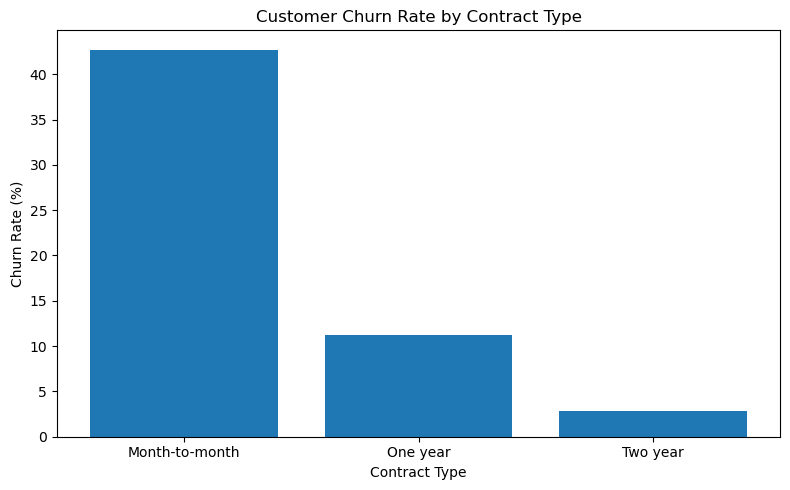

In [12]:
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure reports directory exists
Path("../../reports").mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8, 5))
plt.bar(contract_churn["Contract"], contract_churn["churn_rate"])
plt.xlabel("Contract Type")
plt.ylabel("Churn Rate (%)")
plt.title("Customer Churn Rate by Contract Type")
plt.tight_layout()

plt.savefig("../../reports/churn_by_contract.png", dpi=150)
plt.show()

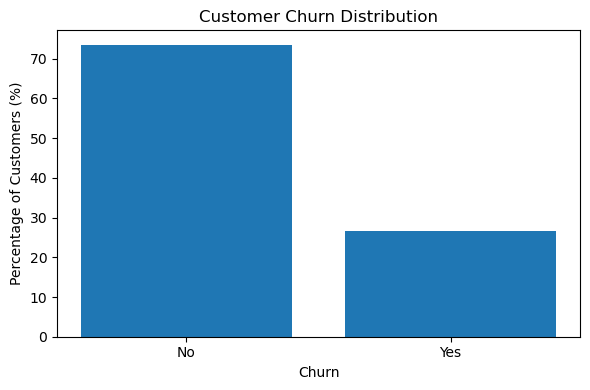

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(churn_counts.index, churn_percent.values)
plt.title("Customer Churn Distribution")
plt.ylabel("Percentage of Customers (%)")
plt.xlabel("Churn")
plt.tight_layout()
plt.savefig("../../reports/churn_distribution.png", dpi=150)
plt.show()

### Insight — Churn by Contract Type

Customers on **month-to-month contracts show a dramatically higher churn rate** compared to those on longer-term contracts.

While only **~27% of total customers churn overall**, the churn rate for month-to-month customers exceeds **40%**, indicating a strong lack of long-term commitment.

In contrast, customers with **one-year and two-year contracts exhibit significantly lower churn**, suggesting that contract duration acts as a powerful retention mechanism.

This pattern indicates that churn is **not random**, but strongly influenced by **contract structure and switching costs**, making contract type one of the most important drivers of customer retention.

In [13]:
# Churn rate by Internet Service

internet_churn = (
    df.groupby("InternetService", observed=False)
      .agg(
          customers=("customerID", "count"),
          churn_rate=("Churn", lambda x: (x == "Yes").mean() * 100)
      )
      .reset_index()
)

internet_churn

,InternetService,customers,churn_rate
0,DSL,2421,18.959108
1,Fiber optic,3096,41.892765
2,No,1526,7.404980


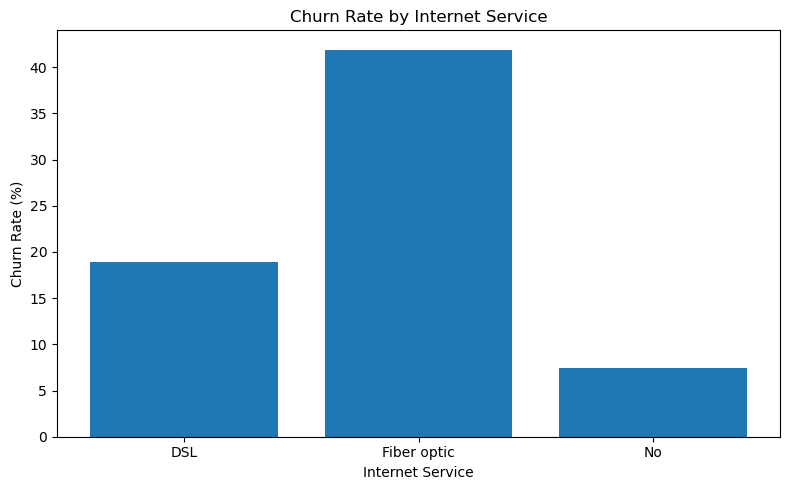

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(
    internet_churn["InternetService"],
    internet_churn["churn_rate"]
)

plt.xlabel("Internet Service")
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Internet Service")
plt.tight_layout()

plt.savefig("../../reports/churn_by_internet_service.png", dpi=150)
plt.show()

### 🔍 Insights — Internet Service & Churn

- Customers using **Fiber optic** show a **significantly higher churn rate (~42%)** compared to DSL (~19%) and customers without internet service (~7%).
- Despite being a premium offering, **Fiber optic customers are the most likely to leave**, suggesting unmet expectations or service quality issues.
- Customers with **no internet service** exhibit the lowest churn, likely because they rely on fewer services and face lower complexity or costs.
- This pattern indicates that **churn is not driven by lack of features**, but potentially by:
  - Service reliability issues
  - Price sensitivity
  - Poor customer support experience for Fiber optic users

**Business implication:**  
Fiber optic customers should be treated as a **high-risk segment**, requiring targeted retention strategies such as service quality audits, proactive support, or pricing reviews.

In [17]:
# Churn rate by payment method

payment_churn = (
    df.groupby("PaymentMethod", observed=False)
      .agg(
          customers=("customerID", "count"),
          churn_rate=("Churn", lambda x: (x == "Yes").mean() * 100)
      )
      .reset_index()
      .sort_values("churn_rate", ascending=False)
)

payment_churn

,PaymentMethod,customers,churn_rate
2,Electronic check,2365,45.285412
3,Mailed check,1612,19.106700
0,Bank transfer (automatic),1544,16.709845
1,Credit card (automatic),1522,15.243101


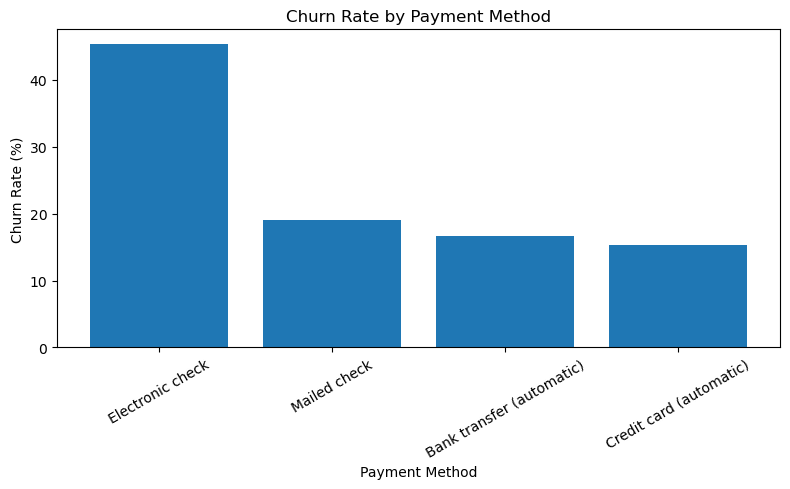

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(payment_churn["PaymentMethod"], payment_churn["churn_rate"])
plt.ylabel("Churn Rate (%)")
plt.xlabel("Payment Method")
plt.title("Churn Rate by Payment Method")
plt.xticks(rotation=30)
plt.tight_layout()

plt.savefig("../../reports/churn_by_payment_method.png", dpi=150)
plt.show()

### Insight — Payment Method and Churn

Customer churn varies significantly by payment method:

- **Electronic check customers show the highest churn rate (~45%)**, more than double any other payment method.
- Customers using **automatic payment methods (bank transfer or credit card)** have the **lowest churn rates (~15–17%)**.
- **Mailed check users** fall in between, with moderate churn.

This pattern suggests that **payment convenience and automation are strongly linked to customer retention**.

Electronic check users are more likely to:
- Miss payments
- Experience billing friction
- Have a lower commitment to the service

Automatic payments, on the other hand, reduce friction and increase customer stickiness.

This highlights a **non-product-related churn driver** that can be addressed through billing strategy rather than pricing or service changes.

### Insight — Internet Service Type and Churn

Churn rates differ substantially depending on the type of internet service:

- **Fiber optic customers exhibit the highest churn rate (~42%)**, more than double that of DSL customers.
- **DSL users show moderate churn (~19%)**, while customers without internet service have the **lowest churn (~7%)**.
  
Despite fiber optic being a premium, high-speed product, it is associated with significantly higher customer churn.  
This suggests that **churn is not driven by lack of product capability**, but rather by:

- Higher prices
- Service reliability issues
- Higher customer expectations that may not be met

This finding highlights a **risk in premium product segments**, where customer expectations are higher and tolerance for issues is lower.

In [20]:
# Churn rate by TechSupport

techsupport_churn = (
    df.groupby("TechSupport", observed=True)
      .agg(
          customers=("customerID", "count"),
          churn_rate=("Churn", lambda x: (x == "Yes").mean() * 100)
      )
      .reset_index()
      .sort_values("churn_rate", ascending=False)
)

techsupport_churn

,TechSupport,customers,churn_rate
0,No,3473,41.635474
2,Yes,2044,15.166341
1,No internet service,1526,7.404980


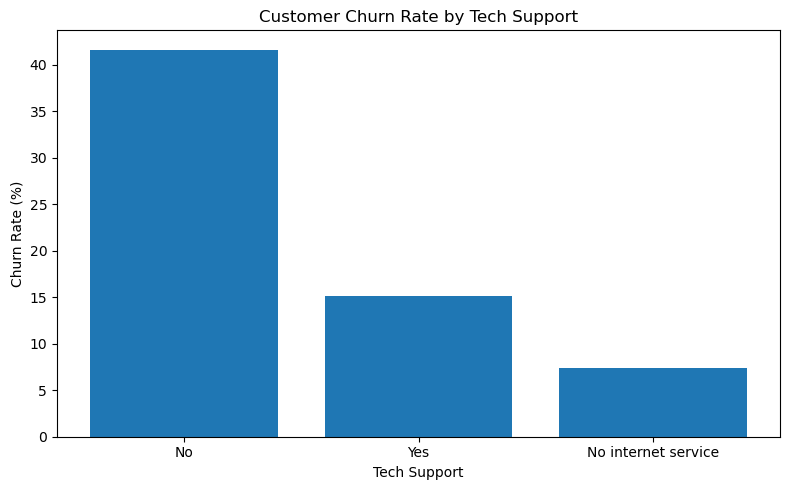

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(
    techsupport_churn["TechSupport"],
    techsupport_churn["churn_rate"]
)

plt.xlabel("Tech Support")
plt.ylabel("Churn Rate (%)")
plt.title("Customer Churn Rate by Tech Support")
plt.tight_layout()

# Save figure
plt.savefig("../../reports/churn_by_techsupport.png", dpi=120)
plt.show()

### Insight — Tech Support and Churn

Customer churn is strongly associated with the availability of technical support:

- Customers **without tech support show the highest churn rate (~42%)**.
- Customers **with tech support have significantly lower churn (~15%)**.
- Customers without internet service show the **lowest churn (~7%)**, likely due to simpler service usage.

This indicates that **technical support acts as a strong retention lever**.

Lack of tech support increases:
- Customer frustration
- Unresolved service issues
- Likelihood of cancellation when problems arise

Providing accessible and effective tech support can significantly reduce churn, especially among internet service customers.

In [25]:
# Churn rate by Monthly Charges (binned)

import pandas as pd

# Create price bins
df["price_group"] = pd.cut(
    df["MonthlyCharges"],
    bins=[0, 35, 60, 90, 120],
    labels=["Low", "Medium", "High", "Very High"]
)

price_churn = (
    df.groupby("price_group", observed=True)
      .agg(
          customers=("customerID", "count"),
          churn_rate=("Churn", lambda x: (x == "Yes").mean() * 100)
      )
      .reset_index()
)

price_churn

,price_group,customers,churn_rate
0,Low,1735,10.893372
1,Medium,1183,25.443787
2,High,2386,33.906119
3,Very High,1739,32.777458


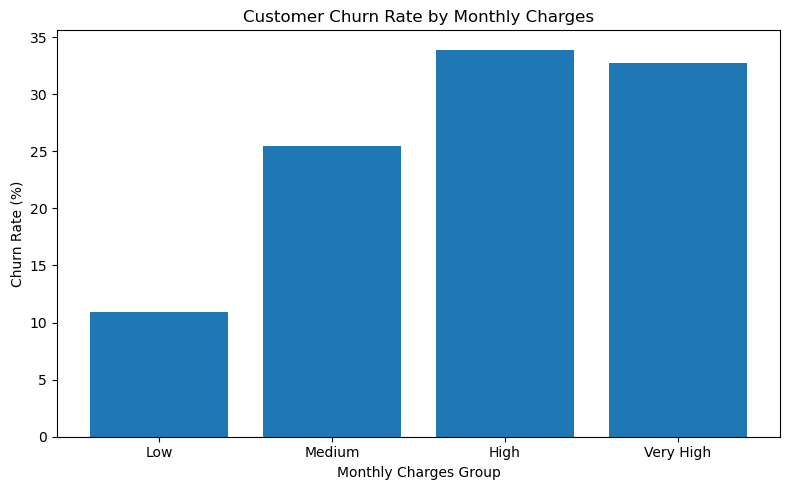

In [26]:
import matplotlib.pyplot as plt
from pathlib import Path

plt.figure(figsize=(8,5))
plt.bar(price_churn["price_group"], price_churn["churn_rate"])
plt.xlabel("Monthly Charges Group")
plt.ylabel("Churn Rate (%)")
plt.title("Customer Churn Rate by Monthly Charges")
plt.tight_layout()

plt.savefig("../../reports/churn_by_monthly_charges.png", dpi=150)
plt.show()

### Insight — Monthly Charges and Churn

Customer churn increases significantly as monthly charges rise:

- **Low-price customers show the lowest churn (~11%)**, indicating strong price-value alignment.
- Churn increases sharply in the **Medium price segment (~25%)**.
- **High and Very High price customers exhibit the highest churn (~33–34%)**.

This pattern suggests that **higher-paying customers are more sensitive to perceived value**, service quality, and pricing fairness.

High churn in premium segments may indicate:
- Price increases not matched by perceived service quality
- Higher customer expectations
- Greater availability of competitive alternatives

This highlights pricing as a **key churn risk factor**, especially when not paired with clear differentiation or superior customer experience.

## Key Churn Drivers — Synthesis

### Key Churn Drivers — Synthesis

The churn analysis reveals a **consistent pattern across multiple dimensions**, pointing to a clear high-risk customer profile.

Customers most likely to churn tend to have:

- **Short tenure (0–12 months)**, indicating early dissatisfaction.
- **Month-to-month contracts**, which provide low commitment and easy exit.
- **Fiber optic internet service**, associated with higher prices and higher expectations.
- **Electronic check payment method**, suggesting billing friction and lower engagement.
- **No tech support**, significantly increasing churn risk.
- **High or very high monthly charges**, amplifying sensitivity to service issues.

These factors reinforce each other, showing that churn is **not driven by a single issue**, but by a combination of:
- Low commitment
- High price sensitivity
- Service complexity
- Friction in billing and support

This explains why retention strategies must be **multi-dimensional**, addressing both pricing structure and customer experience.

## Business Recommendations

Based on the churn analysis, the following actions are recommended:

1. **Reduce reliance on month-to-month contracts**  
   Customers on month-to-month plans show the highest churn rates.  
   Introduce incentives for customers to switch to longer-term contracts (1-year or 2-year), such as discounts, bundled services, or loyalty rewards.

2. **Promote automatic payment methods**  
   Customers using electronic checks have significantly higher churn.  
   Encourage migration to automatic payments (bank transfer or credit card) by offering small monthly discounts or one-time credits.

3. **Improve retention strategies for fiber optic customers**  
   Despite being a premium service, fiber optic users churn at much higher rates.  
   This segment should be prioritized for:
   - Proactive customer support
   - Service quality monitoring
   - Expectation management around pricing and performance

4. **Expand access to technical support**  
   Customers without tech support churn nearly three times more than those with support.  
   Consider including basic tech support in standard plans or offering low-cost add-ons to reduce friction.

5. **Target early-tenure customers aggressively**  
   Churn is highest in the first 12 months.  
   Implement onboarding programs, early check-ins, and proactive engagement during the first year to improve long-term retention.

6. **Use churn drivers to inform pricing strategy**  
   Higher monthly charges are associated with higher churn.  
   Review pricing tiers to ensure perceived value aligns with cost, especially for high-paying customers.

## Executive Conclusion

This analysis shows that customer churn in the telecom business is **not random**, but driven by clear behavioral, contractual, and pricing patterns.

Key findings include:

- **Early tenure is the most critical risk period**, with nearly half of customers churning within the first year.
- **Month-to-month contracts and electronic check payments** are strong churn indicators, pointing to low customer commitment and higher friction.
- **Premium segments (fiber optic and high monthly charges)** experience higher churn, suggesting that expectations are not being met despite higher pricing.
- **Technical support availability significantly reduces churn**, highlighting the importance of service and post-sale experience.

Overall, churn is driven more by **customer experience, billing structure, and contract design** than by demographic factors.

By addressing churn proactively through pricing strategy, contract incentives, payment automation, and early engagement, the business can significantly improve customer retention and lifetime value.

This case demonstrates how **data analysis can uncover actionable churn drivers and directly inform business strategy**.